#                                        Modeling Case Study 

# Introduction:

This study's main goal is to investigate and forecast birthweight, a vital indicator of a newborn's health. 
The probability of newborn health problems and their impact on the well-being of the child are strongly 
correlated with birthweight. 

A lower birthweight can be an indicator of several health issues, such as higher mortality rates, 
increased risk of infection, and developmental delays.

By more specifically focusing on reducing these determinants, public health programs 
can improve neonatal care and lower the incidence of health issues linked to low birthweight.

Because predictive modeling makes it easier to identify pregnancies that are at risk early on, 
it is essential to the neonatal and pediatric healthcare systems. This emphasizes the significance 
of this parameter by enabling prophylactic actions against low birthweight and its related consequences.







# Import and Data check

In [57]:
# importing necessary packages

import numpy                   as np
import pandas                  as pd
import matplotlib.pyplot       as plt
import seaborn                 as sns
import statsmodels.formula.api as smf # logistic regression
import nbformat
import phik                           # phi coefficient
import sklearn.linear_model           # logistic regression
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import power_transform    # yeo-johnson
from sklearn.impute          import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.linear_model    import LogisticRegression, RidgeClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import confusion_matrix, accuracy_score
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier 
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics         import (confusion_matrix, roc_curve, accuracy_score,
                                     auc, classification_report,
                                     roc_auc_score, precision_score, recall_score)

In [58]:
def standard_scaler(df):
    """
    Standardizes a dataset (mean = 0, variance = 1). Returns a new DataFrame.
    Requires sklearn.preprocessing.StandardScaler()
    
    PARAMETERS
    ----------
    df     | DataFrame to be used for scaling
    """

    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler(copy = True)


    # FITTING the scaler with the data
    scaler.fit(df)


    # TRANSFORMING our data after fit
    x_scaled = scaler.transform(df)

    
    # converting scaled data into a DataFrame
    new_df = pd.DataFrame(x_scaled)


    # reattaching column names
    new_df.columns = list(df.columns)
    
    return new_df

In [59]:
## importing data ##

# reading modeling data into Python
train_file = './birthweight.csv'

# calling this bw_train
bw_train = pd.read_csv(train_file,
                       header     = 0,
                       index_col  = 'bwt_id')



# reading testing data into Python
test_file = './kaggle_test_data.csv'

# calling this bw_test
bw_test = pd.read_csv(test_file,
                      header    = 0,
                      index_col = 'bwt_id')

# concatenating datasets together for mv analysis and feature engineering
bw_train['set'] = 'Not Kaggle'
bw_test ['set'] = 'Kaggle'

# concatenating both datasets together for mv and feature engineering
bw_full = pd.concat(objs = [bw_train, bw_test], axis = 0).reset_index(drop = False)
                    #ignore_index = False)

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)


# checking dataset
bw_full.head()

,bwt_id,mage,meduc,monpre,npvis,fage,feduc,omaps,fmaps,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set
0,bwt_1,28,12.0,2,10.0,31.0,17.0,8.0,9.0,0.0,0.0,0,1,0,0,1,0,0,3317.0,Not Kaggle
1,bwt_2,21,NaN,1,6.0,21.0,NaN,8.0,9.0,NaN,NaN,0,1,0,0,1,0,0,1160.0,Not Kaggle
2,bwt_3,27,15.0,2,11.0,32.0,16.0,9.0,9.0,0.0,0.0,1,1,0,0,1,0,0,4706.0,Not Kaggle
3,bwt_4,33,17.0,1,20.0,39.0,17.0,9.0,10.0,0.0,0.0,0,0,0,1,0,0,1,3289.0,Not Kaggle
4,bwt_5,30,15.0,2,12.0,36.0,16.0,9.0,9.0,NaN,NaN,1,1,0,0,1,0,0,3490.0,Not Kaggle


In [60]:
# checking available features
bw_full.columns

Index(['bwt_id', 'mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'omaps', 'fmaps', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 'set'], dtype='object')

In [61]:
# formatting and printing the dimensions of the dataset
print(f"""
Size of Original Dataset
------------------------
Observations (rows): {bw_full.shape[0]}
Features (columns) : {bw_full.shape[1]}
""")


Size of Original Dataset
------------------------
Observations (rows): 473
Features (columns) : 20



# Data Preparation

## Exploratory Data Analysis (EDA)

In [62]:
## Descriptive statistics

print(bw_full.describe().round(2))

print("\n\n")

#checking for data types and null values
print(bw_full.info())


         mage   meduc  monpre   npvis    fage   feduc   omaps   fmaps    cigs   drink    male   mwhte   mblck    moth   fwhte   fblck    foth    bwght
count  473.00  467.00  473.00  452.00  472.00  463.00  471.00  471.00  440.00  441.00  473.00  473.00  473.00  473.00  473.00  473.00  473.00   409.00
mean    29.78   13.68    2.21   11.54   32.17   13.87    8.23    8.95    1.17    0.02    0.51    0.87    0.07    0.05    0.88    0.07    0.05  3189.87
std      5.11    2.14    1.33    3.92    6.10    2.22    1.37    0.58    4.21    0.30    0.50    0.34    0.26    0.23    0.33    0.26    0.22   748.45
min     16.00    3.00    0.00    0.00   18.00    6.00    1.00    5.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   360.00
25%     26.00   12.00    1.00   10.00   28.00   12.00    8.00    9.00    0.00    0.00    0.00    1.00    0.00    0.00    1.00    0.00    0.00  2780.00
50%     30.00   13.00    2.00   12.00   32.00   14.00    9.00    9.00    0.00    0.00    1.00 

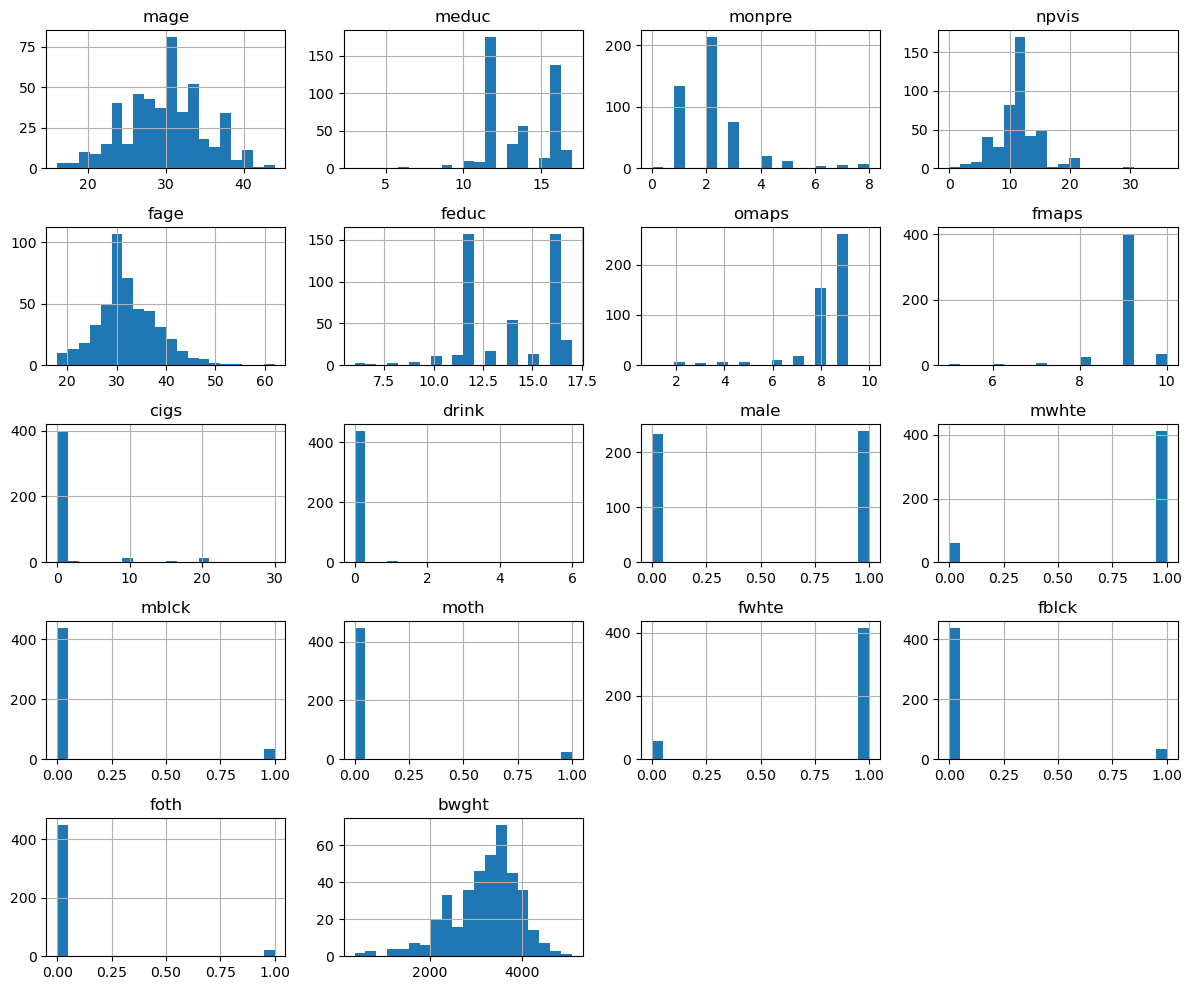

In [63]:
# Visualize distributions of numerical features
bw_full.hist(figsize = (12, 10),
             bins    = 20)
plt.tight_layout()
plt.show()

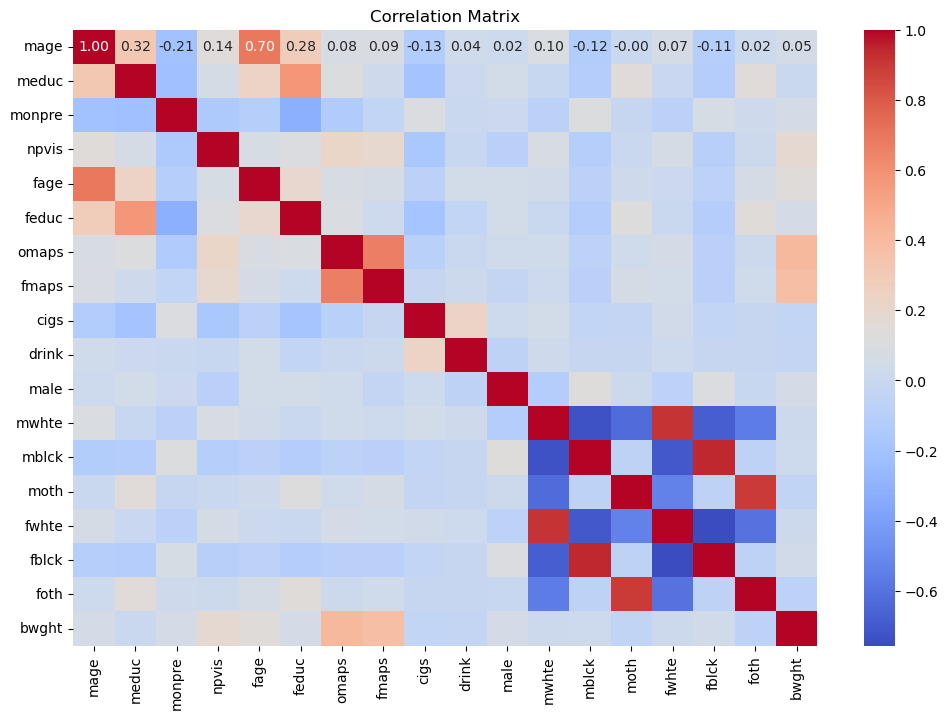

In [64]:
#Heat Map

plt.figure(figsize = (12, 8))
sns.heatmap(bw_full.corr(numeric_only = 1),
            annot = True,
            fmt   = '.2f',
            cmap  = 'coolwarm')
plt.title('Correlation Matrix')

plt.show()

In [65]:
# developing a correlation matrix
bw_full_corr = bw_full.corr(method = 'pearson',numeric_only = True)


# filtering results to show correlations with bwght
bw_full_corr_bw=bw_full_corr.loc[ : , "bwght"].round(decimals = 2).sort_values(ascending = False)
bw_full_corr_bw

bwght     1.00
omaps     0.41
fmaps     0.38
npvis     0.18
fage      0.14
male      0.06
monpre    0.06
feduc     0.06
mage      0.05
fblck     0.04
mwhte     0.02
mblck     0.02
fwhte     0.02
meduc     0.00
drink    -0.03
cigs     -0.04
moth     -0.05
foth     -0.07
Name: bwght, dtype: float64

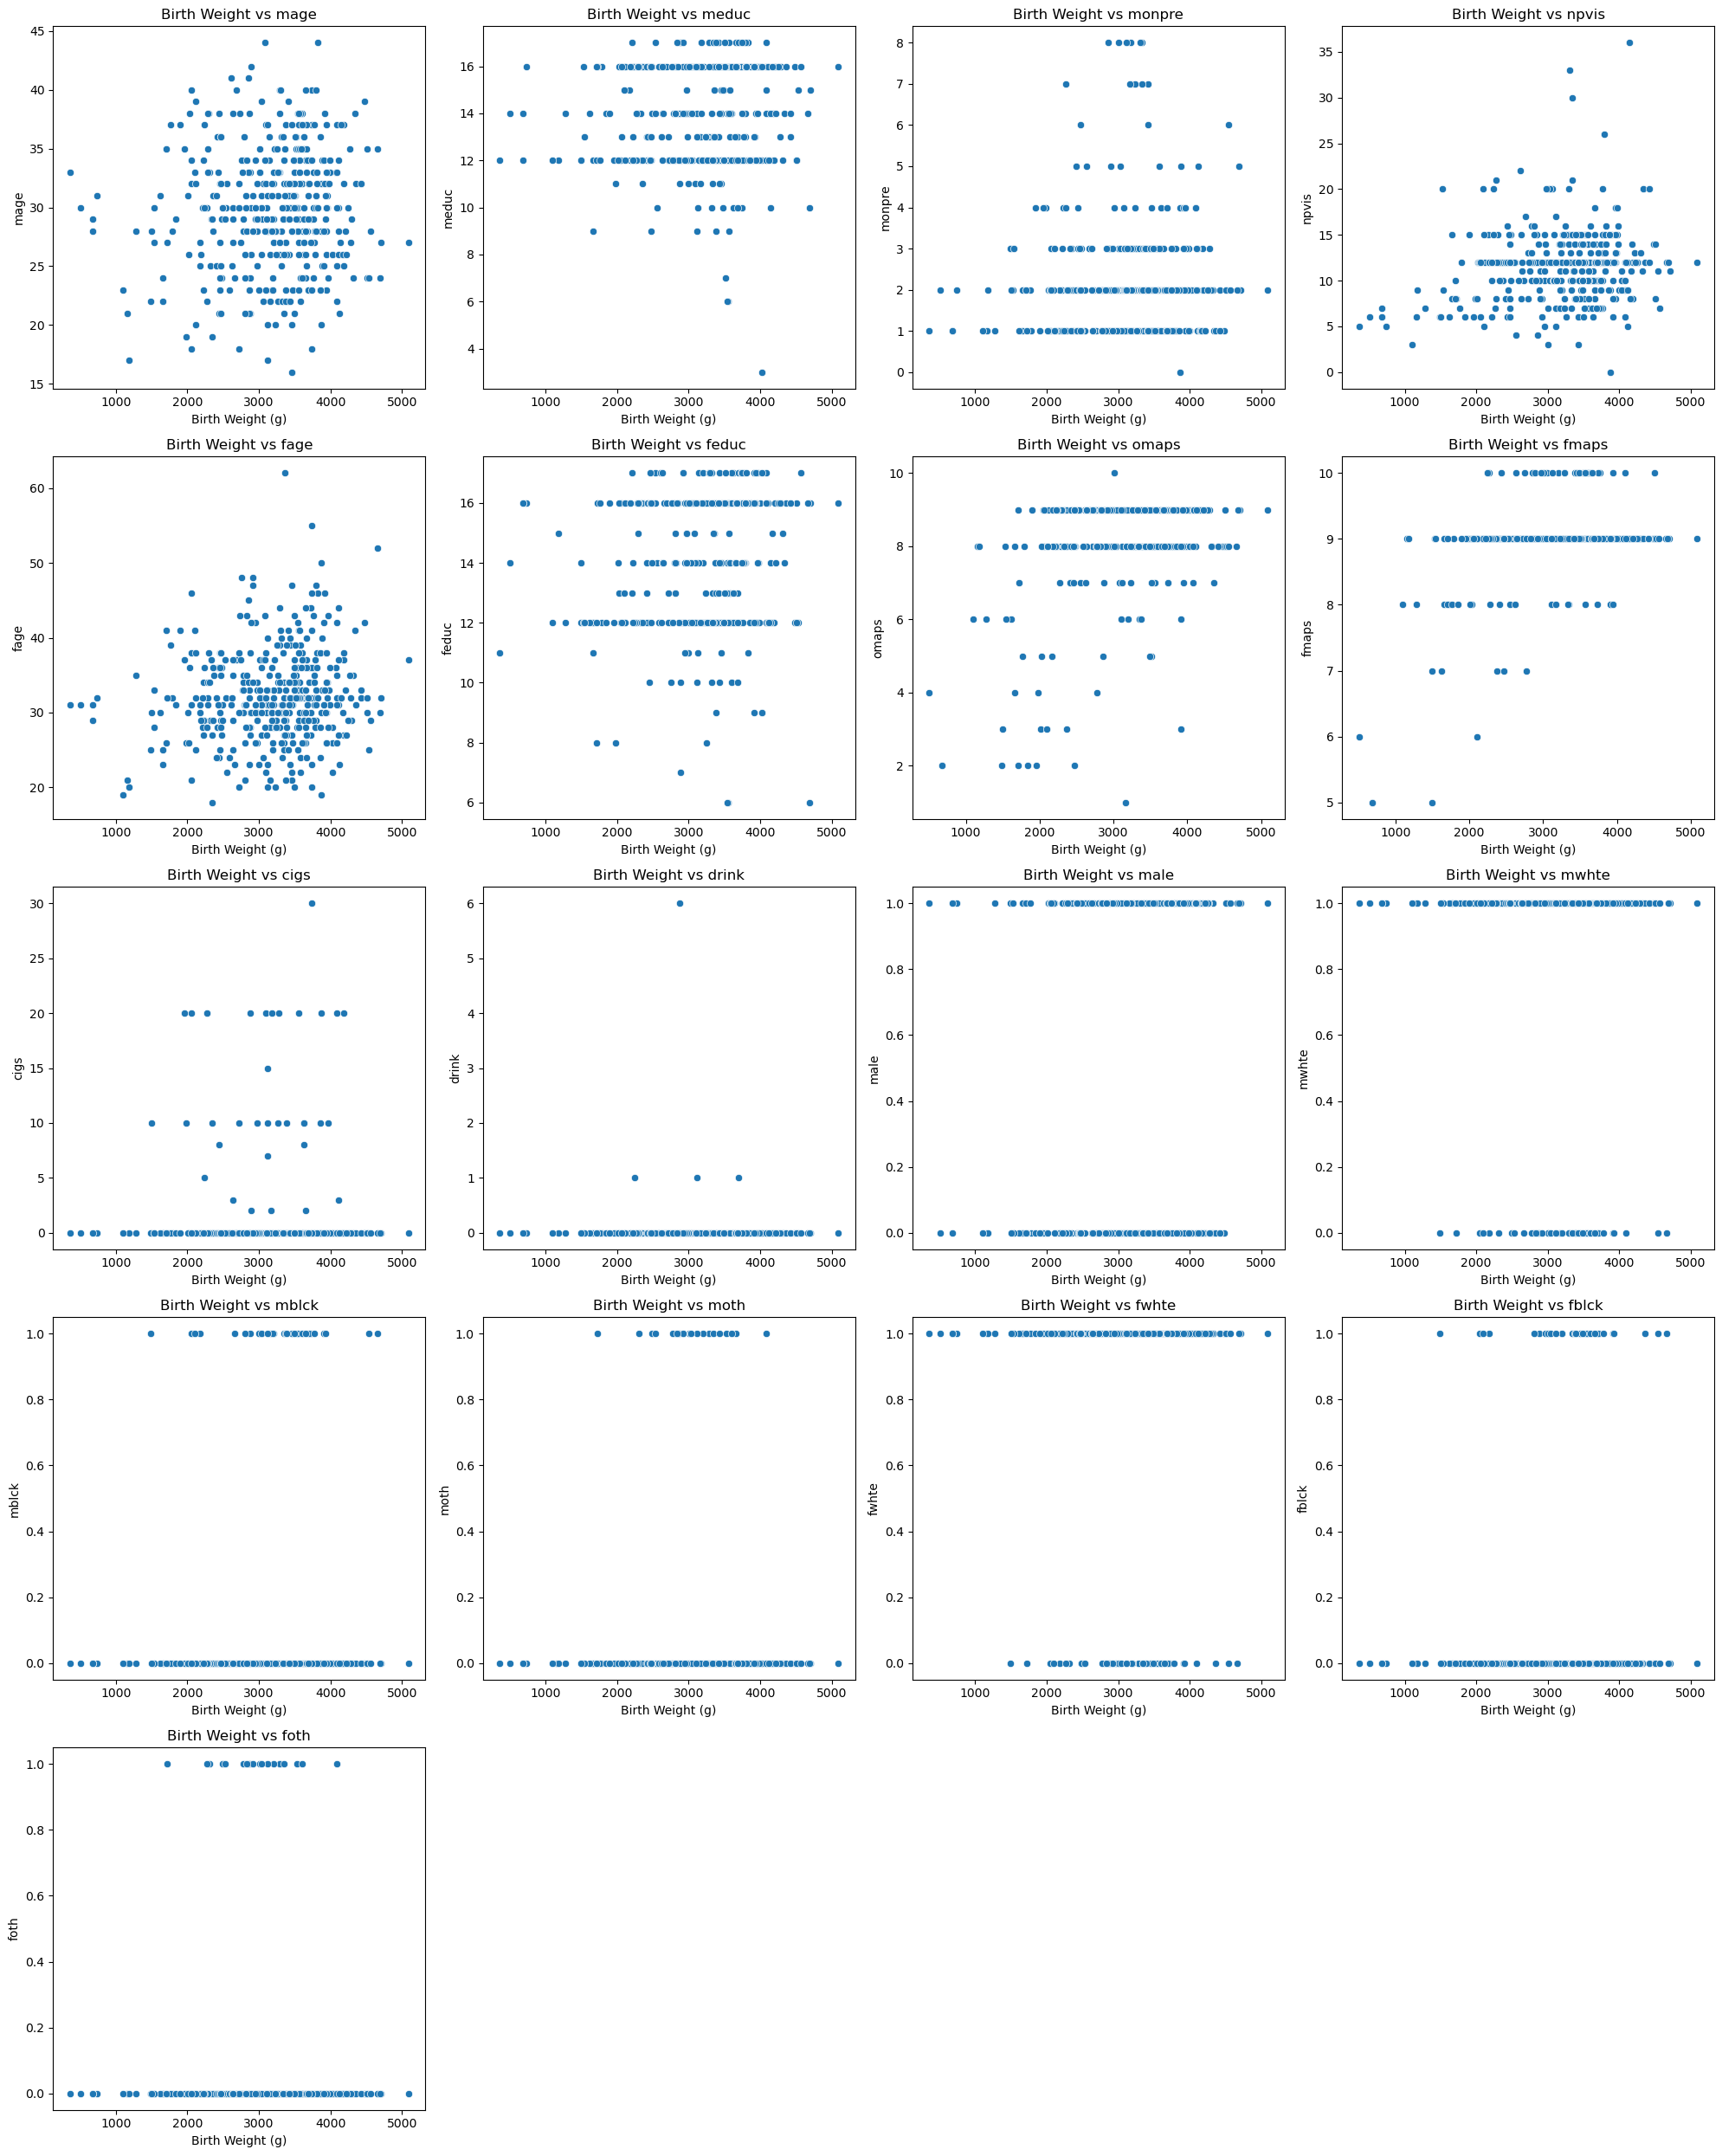

In [66]:
features = ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'omaps', 'fmaps', 
            'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth']

# Plot setup
fig, axs = plt.subplots(5, 4, figsize=(20, 25)) 
axs = axs.flatten()

# Loop through features and create scatter plots
for i, feature in enumerate(features):
    sns.scatterplot(x=bw_full['bwght'], y=bw_full[feature], ax=axs[i])
    axs[i].set_title(f'Birth Weight vs {feature}')
    axs[i].set_xlabel('Birth Weight (g)')
    axs[i].set_ylabel(feature)


for ax in axs[i+1:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

Correlation with Birth weight:


The correlation matrix offers important information about the variables related to birthweight. This illustrates how prenatal care and 
the father's age positively influence baby weights by providing better health support and stability, leading to healthier pregnancies and heavier babies.
On the other hand, it highlights the detrimental effects of maternal drinking and smoking, which deprive the fetus of nutrition and oxygen, 
introduce contaminants, lower birth weights, and possible health issues. These variables collectively impair neonatal health.
 
This has been evidentlly proved from the above visualization.

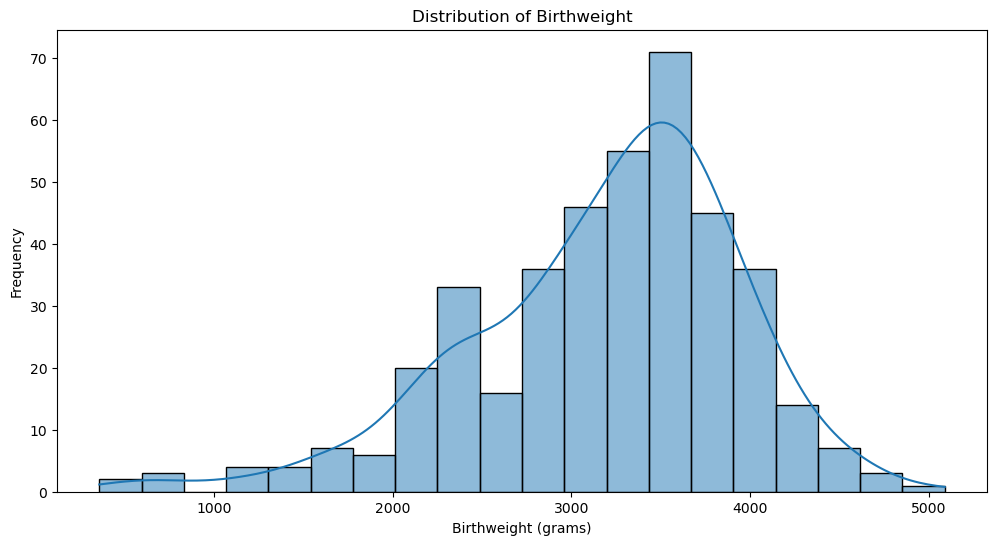

In [67]:
# Histogram for birthweight

plt.figure(figsize = (12, 6))

sns.histplot(bw_full['bwght'], kde = True)
plt.title('Distribution of Birthweight')
plt.xlabel('Birthweight (grams)')
plt.ylabel('Frequency')

plt.show()

##  Missing Value Analysis and Imputation

In [68]:
# Check for missing values
bw_full.isnull().sum()

bwt_id     0
mage       0
meduc      6
monpre     0
npvis     21
fage       1
feduc     10
omaps      2
fmaps      2
cigs      33
drink     32
male       0
mwhte      0
mblck      0
moth       0
fwhte      0
fblck      0
foth       0
bwght     64
set        0
dtype: int64

In [69]:
# dropping post-event horizon features (omaps, fmaps)(occured after baby birth)

bw_full = bw_full.drop(labels = ['omaps',"fmaps"],
                       axis   = 1     )

Imputation method:
    
Using the "median" value through a Simple Imputer to fill in the missing data,and 
assuming a value of "0" for "cigs" and "drink" to indicate uncertainty about 
whether these individuals smoke or drink.


In [70]:
from sklearn.impute import SimpleImputer
imputer_numeric = SimpleImputer(strategy='median')

bw_full[["meduc","npvis","fage","feduc"]] = imputer_numeric.fit_transform(bw_full[["meduc","npvis","fage","feduc"]])


# imputing Na values in cigs and drink

bw_full['cigs'].fillna(0, inplace=True)
bw_full['drink'].fillna(0, inplace=True)

In [71]:
# Check for missing values after imputation 

bw_full.isnull().sum()

bwt_id     0
mage       0
meduc      0
monpre     0
npvis      0
fage       0
feduc      0
cigs       0
drink      0
male       0
mwhte      0
mblck      0
moth       0
fwhte      0
fblck      0
foth       0
bwght     64
set        0
dtype: int64

## Feature Engineering

In [72]:
# total education of parents
bw_full['total_parent_educ']   = bw_full['meduc'] + bw_full['feduc']

#prenatal_care_per_month
bw_full['prenatal_care_per_month'] = bw_full['npvis']/(9 - bw_full['monpre'])

#Damage 
bw_full['Damage_index'] = (bw_full['cigs'] * 7) + bw_full['drink']

#checking features
bw_full.columns

Index(['bwt_id', 'mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 'set', 'total_parent_educ', 'prenatal_care_per_month', 'Damage_index'], dtype='object')

Feature Explanation:

1-Total_Parent_Education is the factor indicating the education receieved by both parents.

2-prenatal_care_per_month is the medicare availed by mother during the pregnancy period

3-Damage_index indicates is the negative health index of the mother associated with her social habits. 

Features impacting Birth weights:
    
1-  npvis(0.18): indicates the frequent and timely pre natal visits that mother performs during pregnancy.
This higlights the healthcare received during pregnancy for healthy babies influencing their weights.

Actionable insights:promote regular prenatal care to monitor development.
    
2-  cigs(-0.04) and drinking (-0.03) have adverse effects on mothers health.This will deteriorate babies health 
correspondingly, thus affecting their weights. 
     
Actionable insights: Recommending mother to quit smoking and drinking during the preganancy period, and be
cautious during social events.

In [73]:
# developing a correlation matrix
bw_full_corr = bw_full.corr(method = 'pearson',numeric_only = True)


# filtering results to show correlations with bwght
bw_full_corr_bw=bw_full_corr.loc[ : , "bwght"].round(decimals = 2).sort_values(ascending = False)
bw_full_corr_bw

bwght                      1.00
npvis                      0.18
fage                       0.14
monpre                     0.06
feduc                      0.06
prenatal_care_per_month    0.06
male                       0.06
mage                       0.05
fblck                      0.04
total_parent_educ          0.03
fwhte                      0.02
mwhte                      0.02
mblck                      0.02
meduc                      0.00
drink                     -0.03
cigs                      -0.03
Damage_index              -0.03
moth                      -0.05
foth                      -0.07
Name: bwght, dtype: float64

## Threshold for predicting low birthweight

In [74]:
# Convert birthweight into a binary classification problem (low birthweight as 1, otherwise 0)

bw_full['bwght_category'] = (bw_full['bwght'] < 2500).astype(int)

Threshold Explanation:
    
Low birthweight is defined by the World Health Organization (WHO) as a weight of 2,500 grams (5 pounds, 8 ounces) 
or less at birth. Babies that weigh less than this threshold are more likely to experience respiratory problems,
developmental difficulties, and early developmental obstacles. 

Babies below this weight are prone to more health issues and lower immuntiy. Which could be avoided with predicting 
and forecasting model.




In [75]:
# creating feature sets
continuous     = ['bwght', 'mage', 'fage','prenatal_care_per_month']

non_continuous = [ 'meduc', 'monpre', 'npvis', 'feduc', 'cigs', 'drink', 
                  'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 
                  'total_parent_educ', 'Damage_index']
# pearson correlation
bw_corr = bw_full[ continuous ].corr(method = 'pearson').round(decimals = 4)


# phi coefficient
bw_phi_corr =bw_full[ non_continuous ].phik_matrix(interval_cols = non_continuous).round(decimals = 4)


# checking results
print(f"""
Point-Biserial Correlations
---------------------------
{bw_corr.loc[ : , 'bwght' ].sort_values(ascending = False)}


Phi Coefficients
----------------
{bw_phi_corr.loc[ : , 'bwght' ].sort_values(ascending = False)}
""")


Point-Biserial Correlations
---------------------------
bwght                      1.0000
fage                       0.1387
prenatal_care_per_month    0.0609
mage                       0.0546
Name: bwght, dtype: float64


Phi Coefficients
----------------
bwght                1.0000
total_parent_educ    0.4480
npvis                0.3578
feduc                0.3055
foth                 0.1277
moth                 0.1086
mwhte                0.1006
monpre               0.0896
fwhte                0.0727
male                 0.0376
meduc                0.0000
cigs                 0.0000
drink                0.0000
mblck                0.0000
fblck                0.0000
Damage_index         0.0000
Name: bwght, dtype: float64



Impact of Threshold Transformation on Correlations/Phi Coefficients:

The study more clearly reveals important factors influencing birth weight after 
transforming the birth weight data by applying a threshold and recalculating 
correlations and phi coefficients. Stronger relationships—such as those involving 
prenatal visits and parental education—are highlighted by the metamorphosis, 
underscoring their influence on birth weight. This approach does, however, also 
highlight the possibility that some variables—such as drinking, smoking, and their 
combined damage index—may have more nuanced effects that are not entirely reflected by binary classification.

# separating the data set

In [76]:
## parsing out testing data (needed for later) ##

# dataset for kaggle
test_data = bw_full[ bw_full['set'] == 'Kaggle' ].copy()


# dataset for model building
train_data = bw_full[ bw_full['set'] == 'Not Kaggle' ].copy()


# dropping set identifier (kaggle)
test_data.drop(labels = 'set',
                 axis = 1,
                 inplace = True)


# dropping set identifier (model building)
train_data.drop(labels = 'set',
                axis = 1,
                inplace = True)

# Transforming and Standardization

In [77]:
from sklearn.preprocessing import power_transform
# setting x-data
x_data = train_data.drop(labels = ['bwght',"bwt_id",'bwght_category','mage', 'drink',
                                   'mblck','fwhte','fblck','Damage_index'
                                   ],
                         axis   = 1)

# yeo-johnson transformation
x_transformed = power_transform(X           = x_data,
                                method      = 'yeo-johnson',
                                standardize = True        )


# storing results as a DataFrame
x_transformed_df = pd.DataFrame(data    = x_transformed,
                                columns = list(x_data.columns))

In [78]:
from sklearn.preprocessing import StandardScaler
# checking skewness results
x_transformed_df.skew().round(decimals = 2)

# standardizing X-data (st = scaled and transformed)
x_data_st = standard_scaler(df = x_transformed_df)

# checking results
x_data_st.describe(include = 'number').round(decimals = 2)

,meduc,monpre,npvis,fage,feduc,cigs,male,mwhte,moth,foth,total_parent_educ,prenatal_care_per_month
count,409.00,409.00,409.00,409.00,409.00,409.00,409.00,409.00,409.00,409.00,409.00,409.00
mean,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.52,-4.63,-4.78,-2.89,-2.61,-0.31,-0.98,-2.62,-0.24,-0.23,-2.98,-7.05
25%,-0.82,-1.29,-0.36,-0.66,-0.92,-0.31,-0.98,0.38,-0.24,-0.23,-0.96,-0.40
50%,-0.37,0.09,0.19,0.04,-0.06,-0.31,-0.98,0.38,-0.24,-0.23,0.04,0.11
75%,1.14,0.88,0.19,0.67,0.98,-0.31,1.02,0.38,-0.24,-0.23,1.22,0.53
max,1.70,2.48,4.89,3.72,1.56,3.22,1.02,0.38,4.19,4.30,1.88,4.34


In [79]:
# survival proportions
train_data.loc[ : ,'bwght_category'].value_counts(normalize = True).round(decimals = 2)


bwght_category
0    0.8
1    0.2
Name: proportion, dtype: float64

In [80]:
# Candidate Modeling

# Assuming 'bwght' is the target variable
X = x_data_st
y = train_data['bwght_category']

In [81]:
from sklearn.model_selection import train_test_split
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size    = 0.25,
                                                    random_state = 702,
                                                    stratify     = y)

# Model Development

In [82]:
model_result = []



# Logistic Regression model

logistic_model = LogisticRegression(max_iter = 1999)

logistic_model.fit(X_train, y_train)
train_pred_lr = logistic_model.predict(X_train)
y_pred_lr     = logistic_model.predict(X_test)

# Predicting and evaluating the model
acc_train_lr = accuracy_score(y_train, train_pred_lr)
acc_test_lr  = accuracy_score(y_test, y_pred_lr)
gap_lr       = abs(acc_train_lr - acc_test_lr)
auc_test_lr  = roc_auc_score(y_test, y_pred_lr)

model_result.append(['Logistic Regression', acc_train_lr, acc_test_lr, gap_lr, auc_test_lr])




# Random Forest Classification

rf_model = RandomForestClassifier(random_state = 53)

rf_model.fit(X_train, y_train)
train_pred_rf = rf_model.predict(X_train)
y_pred_rf     = rf_model.predict(X_test)

# Predicting and evaluating the model
acc_train_rf = accuracy_score(y_train, train_pred_rf)
acc_test_rf  = accuracy_score(y_test, y_pred_rf)
gap_rf       = abs(acc_train_rf - acc_test_rf)
auc_test_rf  = roc_auc_score(y_test, y_pred_rf)

model_result.append(['Random Forest Classification', acc_train_rf, acc_test_rf, gap_rf, auc_test_rf])



# K-Nearest Neighbors (KNN) Classification

knn_model = KNeighborsClassifier()

knn_model.fit(X_train, y_train)
train_pred_knn = knn_model.predict(X_train)
y_pred_knn     = knn_model.predict(X_test)

# Predicting and evaluating the model
acc_train_knn = accuracy_score(y_train, train_pred_knn)
acc_test_knn  = accuracy_score(y_test, y_pred_knn)
gap_knn       = abs(acc_train_knn - acc_test_knn)
auc_test_knn  = roc_auc_score(y_test, y_pred_knn)

model_result.append(['K-Nearest Neighbors (KNN) Classification', acc_train_knn, acc_test_knn, gap_knn, auc_test_knn])



# Ridge Classifier

ridge_model = RidgeClassifier()

ridge_model.fit(X_train, y_train)
train_pred_rc = ridge_model.predict(X_train)
y_pred_rc     = ridge_model.predict(X_test)

# Predicting and evaluating the model
acc_train_rc = accuracy_score(y_train, train_pred_rc)
acc_test_rc  = accuracy_score(y_test, y_pred_rc)
gap_rc       = abs(acc_train_rc - acc_test_rc)
auc_test_rc  = roc_auc_score(y_test, y_pred_rc)

model_result.append(['Ridge Classification', acc_train_rc, acc_test_rc, gap_rc, auc_test_rc])



# GBM Classifier

gbm_model = GradientBoostingClassifier()

gbm_model.fit(X_train, y_train)
train_pred_gbm = gbm_model.predict(X_train)
y_pred_gbm     = gbm_model.predict(X_test)

# Predicting and evaluating the model
acc_train_gbm = accuracy_score(y_train, train_pred_gbm)
acc_test_gbm  = accuracy_score(y_test, y_pred_gbm)
gap_gbm       = abs(acc_train_gbm - acc_test_gbm)
auc_test_gbm  = roc_auc_score(y_test, y_pred_gbm)

model_result.append(['GBM Classification', acc_train_gbm, acc_test_gbm, gap_gbm, auc_test_gbm])



# Decision Tree Classification

dt_model = DecisionTreeClassifier()

dt_model.fit(X_train, y_train)
train_pred_dt = dt_model.predict(X_train)
y_pred_dt     = dt_model.predict(X_test)

# Predicting and evaluating the model
acc_train_dt = accuracy_score(y_train, train_pred_dt)
acc_test_dt  = accuracy_score(y_test, y_pred_dt)
gap_dt       = abs(acc_train_dt - acc_test_dt)
auc_test_dt  = roc_auc_score(y_test, y_pred_dt)

model_result.append(['Decision Tree Classification', acc_train_dt, acc_test_dt, gap_dt, auc_test_dt])




model_result = pd.DataFrame(model_result, columns = ['Model', 'Train ACCURACY', 'Test ACCURACY', 'Train-Test Gap', 'Test AUC']).sort_values('Test AUC', ascending = False)
model_result

,Model,Train ACCURACY,Test ACCURACY,Train-Test Gap,Test AUC
2,K-Nearest Neighbors (KNN) Classification,0.833333,0.805825,0.027508,0.556928
1,Random Forest Classification,0.990196,0.796117,0.194080,0.550904
5,Decision Tree Classification,0.990196,0.669903,0.320293,0.548494
0,Logistic Regression,0.810458,0.805825,0.004632,0.500000
3,Ridge Classification,0.807190,0.805825,0.001364,0.500000
4,GBM Classification,0.905229,0.728155,0.177073,0.489759


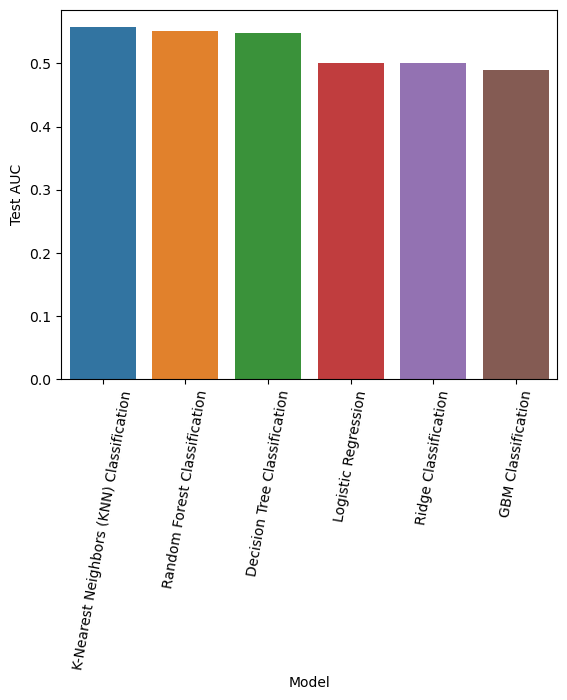

In [83]:
sns.barplot(x = model_result['Model'],
            y = model_result['Test AUC'])
plt.xticks(rotation = 80)
plt.show()

Model Impact:


Compared to the Decision Tree model, K-Nearest Neighbors (KNN) and Random Forest 
were found to have less overfitting and better generalization to new data, as 
demonstrated by smaller train-test gaps and higher test accuracy. These models
show a reasonable capacity to classify correctly while having middling 
Test AUC scores; Random Forest provides solid unseen data performance, and 
KNN shows the least amount of overfitting, making them the preferable options 
for balanced model performance.


In [ ]:
# K-Nearest Neighbors(knn)

In [84]:
#Hyperparameter tuning for Knn
from sklearn.model_selection import GridSearchCV
from math import sqrt

# Create KNN regressor
knn = KNeighborsClassifier()

# Define the parameter range to test
param_grid = {'n_neighbors': range(1, 31), 'weights': ['uniform', 'distance'],}

# Setup GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score (note: score here is negative MSE)
print("Best Parameters:", grid_search.best_params_)


# Predict on the test data using the best parameters
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test)

Best Parameters: {'n_neighbors': 14, 'weights': 'uniform'}


In [85]:
full_knn= KNeighborsClassifier(n_neighbors=14, 
                              weights='uniform')
# FITTING to the training data
full_knn_fit = full_knn.fit(X_train, y_train)


# PREDICTING based on the testing set
full_knn_predict = full_knn_fit.predict(X_test)

# SCORING the results
print('Training ACCURACY:', round(full_knn_fit.score(X_train, y_train),
                                  ndigits = 4))
      
print('Testing ACCURACY :', round(full_knn_fit.score(X_test, y_test),
                                  ndigits = 4))
      
print('AUC Score        :', round(roc_auc_score(y_true  = y_test,
                                                y_score = full_knn_predict),
                                  ndigits = 4))



Training ACCURACY: 0.8072
Testing ACCURACY : 0.8155
AUC Score        : 0.525


In [42]:
from sklearn.metrics import precision_score, recall_score

# Assuming 'y_test' is your true class labels and 'full_knn_predict' are the predicted class labels from your KNN model
precision = precision_score(y_test, full_knn_predict)
recall = recall_score(y_test, full_knn_predict)

print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))

Precision: 1.0
Recall: 0.05


In [86]:
# unpacking the confusion matrix
full_knn_tn, \
full_knn_fp, \
full_knn_fn, \
full_knn_tp = confusion_matrix(y_true = y_test, y_pred =full_knn_predict ).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_knn_tn}
False Positives: {full_knn_fp}
False Negatives: {full_knn_fn}
True Positives : {full_knn_tp}
""")


True Negatives : 83
False Positives: 0
False Negatives: 19
True Positives : 1



In [ ]:
# Random Forest 

In [87]:
# INSTANTIATING a random forest model with default hyperparameters
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'entropy',
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = True,
                                    random_state     = 702)


# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', round(rf_default_fit.score(X_train, y_train), ndigits = 4))
print('Testing  ACCURACY:', round(rf_default_fit.score(X_test , y_test ), ndigits = 4))


# saving AUC score
print('AUC Score        :', round(roc_auc_score(y_true  = y_test,
                                                y_score = rf_default_fit_pred), ndigits = 4))

Training ACCURACY: 0.9902
Testing  ACCURACY: 0.7961
AUC Score        : 0.5699


In [88]:
from sklearn.metrics import precision_score, recall_score

# Assuming 'y_test' is your true class labels and 'full_knn_predict' are the predicted class labels from your KNN model
precision = precision_score(y_test, rf_default_fit_pred)
recall = recall_score(y_test, rf_default_fit_pred)

print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))

Precision: 0.4444
Recall: 0.2


In [89]:
# unpacking the confusion matrix
full_RFC_tn, \
full_RFC_fp, \
full_RFC_fn, \
full_RFC_tp = confusion_matrix(y_true = y_test, y_pred =rf_default_fit_pred  ).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_RFC_tn}
False Positives: {full_RFC_fp}
False Negatives: {full_RFC_fn}
True Positives : {full_RFC_tp}
""")


True Negatives : 78
False Positives: 5
False Negatives: 16
True Positives : 4



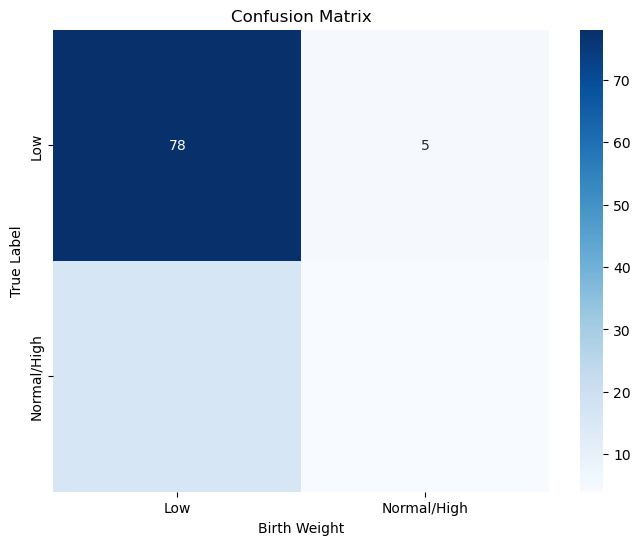

In [90]:
# Confusion Matrix for the test set
cm = confusion_matrix(y_true = y_test, y_pred =rf_default_fit_pred  )

# Plotting the confusion matrix
plt.figure(figsize = (8, 6))

sns.heatmap(cm,
            annot       = True,
            fmt         = "d",
            cmap        = "Blues", 
            xticklabels = ['Low', 'Normal/High'],
            yticklabels =['Low', 'Normal/High'])

plt.title('Confusion Matrix')
plt.xlabel('Birth Weight')
plt.ylabel('True Label')

plt.show()

Model Model selection:

At forecasting low birth weight, Random Forest is preferred over KNN because 
recall is crucial in this situation. Recall measures how well the model can 
pinpoint each and every real instance of low birth weight. 
While accuracy counts, maximizing recall is more important 
when making medical or health-related predictions, such as low birth weight, 
in order to identify all possible cases—even if it means some false positives. 
Random Forest is the better option for this particular application because of its higher recall, 
which increases the likelihood that it will identify these crucial cases.

Confusion Matrix:

True Negatives (TN): 78 - Correctly identified normal birth weight.

False Positives (FP): 5 - Incorrect low birth weight predictions

False Negatives (FN): 16 - Missed low birth weight cases,incorrectly identifies as healthy.

True Positives (TP): 4 - Accurately identified low birth weight, key for timely interventions.
        
    

Importance of Error Controll:

False Negatives are the most worrisome errors when it comes to low birth weight 
prediction since they indicate instances in which the model failed to identify 
babies who are genuinely at risk. Initiating appropriate treatment and interventions 
to decrease related health risks is imperative when low birth weight is detected early. 
The goal is to identify all newborns at risk, even if it implies that some cases may be 
mistakenly labeled. For this reason, decreasing False Negatives—thus optimizing recall—is more 
important in this scenario than reducing False Positives.

# Preparing  for prediction

In [91]:
# Selecting the features for prediction
X_test = test_data.drop(labels = ['bwght',"bwt_id",'bwght_category','mage', 'drink','mblck','fwhte','fblck','Damage_index'
                                   ],
                        axis   = 1)


# yeo-johnson transformation
x_test_tf = power_transform(X           = X_test,
                            method      = 'yeo-johnson',
                            standardize = True        )

In [92]:
# storing results as a DataFrame
x_test_tf_df = pd.DataFrame(data    = x_test_tf,
                            columns = list(X_test.columns))


# checking skewness results
x_test_tf_df.skew().round(decimals = 2)

# standardizing X-data (st = scaled and transformed)
x_test_st = standard_scaler(df = x_test_tf_df)



In [93]:
# Make predictions using the best estimator from your GridSearchCV
y_pred_test = rf_default.predict(x_test_st)

# Create a submission DataFrame 
submission_df = pd.DataFrame({
    'bwt_id': test_data['bwt_id'],  
    'low_bwght': y_pred_test
}).reset_index(drop = True)

In [94]:
# Define the path for saving your submission file
submission_file_path = './kaggle_submission.csv'

# Save your submission DataFrame to CSV
submission_df.to_csv(submission_file_path, index = False)

# Output the path to the saved file
submission_file_path

'./kaggle_submission.csv'

Reference:
https://www.marsden-weighing.co.uk/blog/factors-affect-baby-birth-weight
